In [1]:
from imutils import face_utils
import numpy as np
import pandas as pd
import glob
from natsort import natsorted, ns
import argparse
import imutils
import dlib
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import random
from numba import cuda
import matplotlib as mtplt
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold


In [ ]:
# Create list of image names and corresponding gender classifications
image_dic = pd.read_excel('../Datasets/labels_B.xlsx')
image_dic = image_dic[['file_name', 'eye_color']] # Choose columns which are of importance
df = pd.DataFrame(image_dic)
df.to_excel('../Datasets/source_eye_color_B2/labels_B2.xlsx',index=False)

In [ ]:
# Separate different eye colours and corresponding labels into separate folders

# brown = 0
# blue = 1
# green = 2
# grey = 3
# black = 4

source_eye_color = pd.read_excel('../Datasets/source_eye_color_B2/labels_B2.xlsx')
source_images_file_paths = glob.glob ("../Datasets/source_images_B2/*.png") #find all paths which match the given path
source_images_file_paths = natsorted(source_images_file_paths) #sort the list of file names such that the image list will be in the correct order

brown_directory = "../Datasets/sorted_sets_B2/Brown/"
blue_directory = "../Datasets/sorted_sets_B2/Blue/"
green_directory = "../Datasets/sorted_sets_B2/Green/"
grey_directory = "../Datasets/sorted_sets_B2/Grey/"
black_directory = "../Datasets/sorted_sets_B2/Black/"

for file_path in source_images_file_paths:
    image = cv2.imread(file_path, cv2.COLOR_RGB2BGR) #read the image
    image_name = os.path.basename(file_path)
    image_label = source_eye_color[source_eye_color['file_name']==image_name]['eye_color'].iloc[0]
    if(image_label == 0):
        directory = ''.join([brown_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 1):
        directory = ''.join([blue_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 2):
        directory = ''.join([green_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 3):
        directory = ''.join([grey_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 4):
        directory = ''.join([black_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    else:
        print("no label")

In [ ]:

eye_colors = ["Brown", "Blue", "Green","Grey","Black"] #Define colors
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file

def get_files(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/sorted_sets_B2/%s/*.png" %color)
    return files

def get_eyes():    
    for color in eye_colors:
        files = get_files(color)  
        filenumber = 0
        # loop over images
        for (i, file_path) in enumerate(files):
            image = cv2.imread(file_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            detections = detector(gray, 1)
            for k,d in enumerate(detections): #For all detected face instances individually
                # determine the facial landmarks for the face region, then
                # convert the landmark (x, y)-coordinates to a NumPy array
                shape = predictor(gray, d)
                shape = face_utils.shape_to_np(shape)

                # loop over the face parts individually
                #for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():

                # extract the ROI (right eye) of the face region as a separate image
                
                items = list(face_utils.FACIAL_LANDMARKS_IDXS.items())
                name, (i,j) = items[4] #the 4th item in the FACIAL_LANDMARKS_IDXS is the right eye
                (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
                roi = image[y:y + h, x:x + w]
                
                out = cv2.resize(roi, (250, 250))
                cv2.imwrite("../Datasets/B2_dataset/%s/%s.jpg" %(color, filenumber), out) #Write image - don't need to worry about keeping track of labels associated because already sorted
                filenumber += 1 #Increment image number
            
# call function
get_eyes() #Call functiona

In [2]:
#Extract features

eye_colors = ["Brown", "Blue", "Green","Grey","Black"] #Define colors

def get_files(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/B2_dataset/%s/*.jpg" %color)
    return files

def make_sets():
    image_inputs = []
    image_labels = []
    for color in eye_colors:
        image_files = get_files(color)
        #Append data and generate labels 0-1
        for item in image_files:
            image = cv2.imread(item) #open image
            features = get_features(image)
            image_inputs.append(features) #append image array to training data list
            image_labels.append(eye_colors.index(color))
            
    training_data, prediction_data, training_labels, prediction_labels = train_test_split(image_inputs,image_labels)
    print(len(training_data))
    print(len(training_labels))
    print(len(prediction_data))
    print(len(prediction_labels))
    return training_data, training_labels, prediction_data, prediction_labels, image_inputs, image_labels

def get_features(image):
    return image.mean(axis=(0,1))

# Run code

training_data, training_labels, prediction_data, prediction_labels, image_inputs, image_labels = make_sets()

6067
6067
2023
2023


In [19]:
print(np.asarray(image_inputs).shape)

(8090, 3)


In [13]:

dataframe=pd.DataFrame(image_inputs, columns=['b','g','r'])

dataframe["Label"] = image_labels

df_brown = dataframe[dataframe["Label"] == 0]
brown_inputs = df_brown.filter(['b','g','r'], axis=1).values
brown_labels = df_brown.filter(['Label'], axis=1).values

df_blue = dataframe[dataframe["Label"] == 1]
blue_inputs = df_blue.filter(['b','g','r'], axis=1).values
blue_labels = df_blue.filter(['Label'], axis=1).values

df_green = dataframe[dataframe["Label"] == 2]
green_inputs = df_green.filter(['b','g','r'], axis=1).values
green_labels = df_green.filter(['Label'], axis=1).values

df_grey = dataframe[dataframe["Label"] == 3]
grey_inputs = df_grey.filter(['b','g','r'], axis=1).values
grey_labels = df_grey.filter(['Label'], axis=1).values

df_black = dataframe[dataframe["Label"] == 4]
black_inputs = df_black.filter(['b','g','r'], axis=1).values
black_labels = df_black.filter(['Label'], axis=1).values



In [14]:
# IQR for outliers

df_brown_inputs = pd.DataFrame(brown_inputs, columns=['b','g','r'])
df_blue_inputs = pd.DataFrame(blue_inputs, columns=['b','g','r'])
df_green_inputs = pd.DataFrame(green_inputs, columns=['b','g','r'])
df_grey_inputs = pd.DataFrame(grey_inputs, columns=['b','g','r'])
df_black_inputs = pd.DataFrame(black_inputs, columns=['b','g','r'])

brown_Q1_b = np.quantile(df_brown_inputs['b'].values,0.25)
brown_Q3_b = np.quantile(df_brown_inputs['b'].values,0.75)
brown_IQR_b = brown_Q3_b - brown_Q1_b
brown_Minimum_b = brown_Q1_b - 1.5*brown_IQR_b
brown_Maximum_b = brown_Q3_b + 1.5*brown_IQR_b

brown_Q1_g = np.quantile(df_brown_inputs['g'].values,0.25)
brown_Q3_g = np.quantile(df_brown_inputs['g'].values,0.75)
brown_IQR_g = brown_Q3_g - brown_Q1_g
brown_Minimum_g = brown_Q1_g - 1.5*brown_IQR_g
brown_Maximum_g = brown_Q3_g + 1.5*brown_IQR_g

brown_Q1_r = np.quantile(df_brown_inputs['r'].values,0.25)
brown_Q3_r = np.quantile(df_brown_inputs['r'].values,0.75)
brown_IQR_r = brown_Q3_r - brown_Q1_r
brown_Minimum_r = brown_Q1_r - 1.5*brown_IQR_r
brown_Maximum_r = brown_Q3_r + 1.5*brown_IQR_r

blue_Q1_b = np.quantile(df_blue_inputs['b'].values,0.25)
blue_Q3_b = np.quantile(df_blue_inputs['b'].values,0.75)
blue_IQR_b = blue_Q3_b - blue_Q1_b
blue_Minimum_b = blue_Q1_b - 1.5*blue_IQR_b
blue_Maximum_b = blue_Q3_b + 1.5*blue_IQR_b

blue_Q1_g = np.quantile(df_blue_inputs['g'].values,0.25)
blue_Q3_g = np.quantile(df_blue_inputs['g'].values,0.75)
blue_IQR_g = blue_Q3_g - blue_Q1_g
blue_Minimum_g = blue_Q1_g - 1.5*blue_IQR_g
blue_Maximum_g = blue_Q3_g + 1.5*blue_IQR_g

blue_Q1_r = np.quantile(df_blue_inputs['r'].values,0.25)
blue_Q3_r = np.quantile(df_blue_inputs['r'].values,0.75)
blue_IQR_r = blue_Q3_r - blue_Q1_r
blue_Minimum_r = blue_Q1_r - 1.5*blue_IQR_r
blue_Maximum_r = blue_Q3_r + 1.5*blue_IQR_r

green_Q1_b = np.quantile(df_green_inputs['b'].values,0.25)
green_Q3_b = np.quantile(df_green_inputs['b'].values,0.75)
green_IQR_b = green_Q3_b - green_Q1_b
green_Minimum_b = green_Q1_b - 1.5*green_IQR_b
green_Maximum_b = green_Q3_b + 1.5*green_IQR_b

green_Q1_g = np.quantile(df_green_inputs['g'].values,0.25)
green_Q3_g = np.quantile(df_green_inputs['g'].values,0.75)
green_IQR_g = green_Q3_g - green_Q1_g
green_Minimum_g = green_Q1_g - 1.5*green_IQR_g
green_Maximum_g = green_Q3_g + 1.5*green_IQR_g

green_Q1_r = np.quantile(df_green_inputs['r'].values,0.25)
green_Q3_r = np.quantile(df_green_inputs['r'].values,0.75)
green_IQR_r = green_Q3_r - green_Q1_r
green_Minimum_r = green_Q1_r - 1.5*green_IQR_r
green_Maximum_r = green_Q3_r + 1.5*green_IQR_r

grey_Q1_b = np.quantile(df_grey_inputs['b'].values,0.25)
grey_Q3_b = np.quantile(df_grey_inputs['b'].values,0.75)
grey_IQR_b = grey_Q3_b - grey_Q1_b
grey_Minimum_b = grey_Q1_b - 1.5*grey_IQR_b
grey_Maximum_b = grey_Q3_b + 1.5*grey_IQR_b

grey_Q1_g = np.quantile(df_grey_inputs['g'].values,0.25)
grey_Q3_g = np.quantile(df_grey_inputs['g'].values,0.75)
grey_IQR_g = grey_Q3_g - grey_Q1_g
grey_Minimum_g = grey_Q1_g - 1.5*grey_IQR_g
grey_Maximum_g = grey_Q3_g + 1.5*grey_IQR_g

grey_Q1_r = np.quantile(df_grey_inputs['r'].values,0.25)
grey_Q3_r = np.quantile(df_grey_inputs['r'].values,0.75)
grey_IQR_r = grey_Q3_r - grey_Q1_r
grey_Minimum_r = grey_Q1_r - 1.5*grey_IQR_r
grey_Maximum_r = grey_Q3_r + 1.5*grey_IQR_r

black_Q1_b = np.quantile(df_black_inputs['b'].values,0.25)
black_Q3_b = np.quantile(df_black_inputs['b'].values,0.75)
black_IQR_b = black_Q3_b - black_Q1_b
black_Minimum_b = black_Q1_b - 1.5*black_IQR_b
black_Maximum_b = black_Q3_b + 1.5*black_IQR_b

black_Q1_g = np.quantile(df_black_inputs['g'].values,0.25)
black_Q3_g = np.quantile(df_black_inputs['g'].values,0.75)
black_IQR_g = black_Q3_g - black_Q1_g
black_Minimum_g = black_Q1_g - 1.5*black_IQR_g
black_Maximum_g = black_Q3_g + 1.5*black_IQR_g

black_Q1_r = np.quantile(df_black_inputs['r'].values,0.25)
black_Q3_r = np.quantile(df_black_inputs['r'].values,0.75)
black_IQR_r = black_Q3_r - black_Q1_r
black_Minimum_r = black_Q1_r - 1.5*black_IQR_r
black_Maximum_r = black_Q3_r + 1.5*black_IQR_r

idx_keep_brown = []
idx_keep_blue = []
idx_keep_green = []
idx_keep_grey = []
idx_keep_black = []

for i, row in enumerate(brown_inputs):
    keep = (((row[0] > brown_Minimum_b) and (row[0] < brown_Maximum_b))
            and ((row[1] > brown_Minimum_g) and (row[1] < brown_Maximum_g))
            and ((row[2] > brown_Minimum_r) and (row[2] < brown_Maximum_r)))    
    if(keep):
        idx_keep_brown.append(i)
        
for i, row in enumerate(blue_inputs):
    keep = (((row[0] > blue_Minimum_b) and (row[0] < blue_Maximum_b))
            and ((row[1] > blue_Minimum_g) and (row[1] < blue_Maximum_g))
            and ((row[2] > blue_Minimum_r) and (row[2] < blue_Maximum_r)))    
    if(keep):
        idx_keep_blue.append(i)
        
for i, row in enumerate(green_inputs):
    keep = (((row[0] > green_Minimum_b) and (row[0] < green_Maximum_b))
            and ((row[1] > green_Minimum_g) and (row[1] < green_Maximum_g))
            and ((row[2] > green_Minimum_r) and (row[2] < green_Maximum_r)))    
    if(keep):
        idx_keep_green.append(i)
        
for i, row in enumerate(grey_inputs):
    keep = (((row[0] > grey_Minimum_b) and (row[0] < grey_Maximum_b))
            and ((row[1] > grey_Minimum_g) and (row[1] < grey_Maximum_g))
            and ((row[2] > grey_Minimum_r) and (row[2] < grey_Maximum_r)))    
    if(keep):
        idx_keep_grey.append(i)

for i, row in enumerate(black_inputs):
    keep = (((row[0] > black_Minimum_b) and (row[0] < black_Maximum_b))
            and ((row[1] > black_Minimum_g) and (row[1] < black_Maximum_g))
            and ((row[2] > black_Minimum_r) and (row[2] < black_Maximum_r)))    
    if(keep):
        idx_keep_black.append(i)

        
idx_keep_brown = np.asarray(idx_keep_brown)
idx_keep_blue = np.asarray(idx_keep_blue)
idx_keep_green = np.asarray(idx_keep_green)
idx_keep_grey = np.asarray(idx_keep_grey)
idx_keep_black = np.asarray(idx_keep_black)

new_brown_inputs_IQR = np.asarray([brown_inputs[i] for i in idx_keep_brown])
new_brown_labels_IQR = np.asarray([brown_labels[i] for i in idx_keep_brown])

new_blue_inputs_IQR = np.asarray([blue_inputs[i] for i in idx_keep_blue])
new_blue_labels_IQR = np.asarray([blue_labels[i] for i in idx_keep_blue])

new_green_inputs_IQR = np.asarray([green_inputs[i] for i in idx_keep_green])
new_green_labels_IQR = np.asarray([green_labels[i] for i in idx_keep_green])

new_grey_inputs_IQR = np.asarray([grey_inputs[i] for i in idx_keep_grey])
new_grey_labels_IQR = np.asarray([grey_labels[i] for i in idx_keep_grey])

new_black_inputs_IQR = np.asarray([black_inputs[i] for i in idx_keep_black])
new_black_labels_IQR = np.asarray([black_labels[i] for i in idx_keep_black])


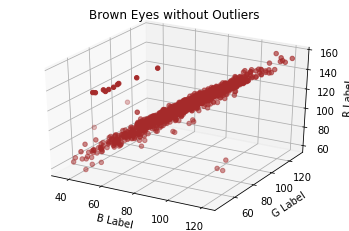

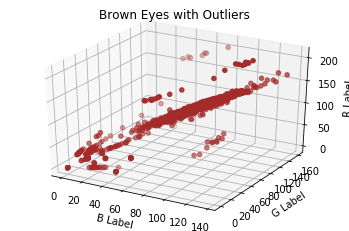

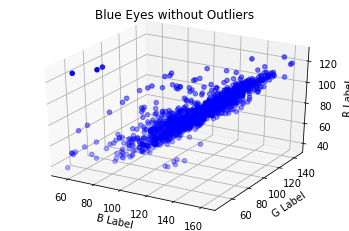

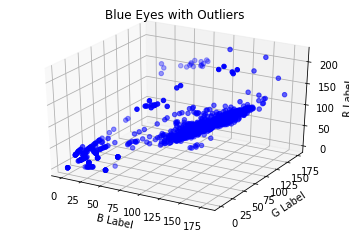

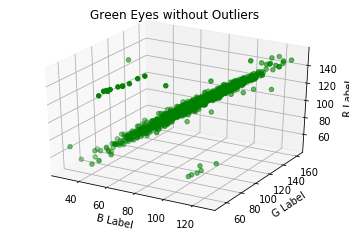

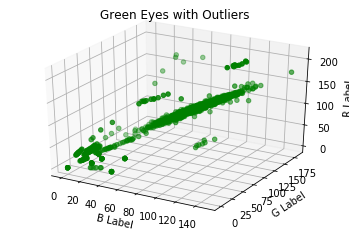

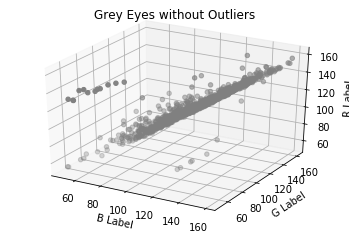

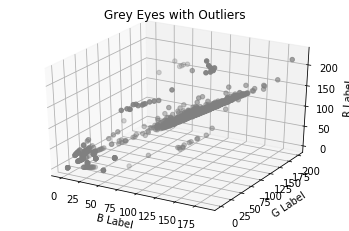

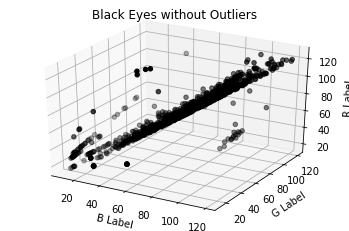

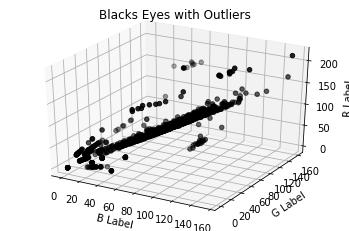

In [15]:
new_df_brown_inputs = pd.DataFrame(new_brown_inputs_IQR, columns=['b','g','r'])
new_df_blue_inputs = pd.DataFrame(new_blue_inputs_IQR, columns=['b','g','r'])
new_df_green_inputs = pd.DataFrame(new_green_inputs_IQR, columns=['b','g','r'])
new_df_grey_inputs = pd.DataFrame(new_grey_inputs_IQR, columns=['b','g','r'])
new_df_black_inputs = pd.DataFrame(new_black_inputs_IQR, columns=['b','g','r'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Brown Eyes without Outliers")
b1 = new_df_brown_inputs['b'].values
g1 = new_df_brown_inputs['g'].values
r1 = new_df_brown_inputs['r'].values
ax.scatter(b1, g1, r1, c='brown', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_removed_brown.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Brown Eyes with Outliers")
b2 = df_brown_inputs['b'].values
g2 = df_brown_inputs['g'].values
r2 = df_brown_inputs['r'].values
ax.scatter(b2, g2, r2, c='brown', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_not_removed_brown.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Blue Eyes without Outliers")
b1 = new_df_blue_inputs['b'].values
g1 = new_df_blue_inputs['g'].values
r1 = new_df_blue_inputs['r'].values
ax.scatter(b1, g1, r1, c='blue', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_removed_blue.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Blue Eyes with Outliers")
b2 = df_blue_inputs['b'].values
g2 = df_blue_inputs['g'].values
r2 = df_blue_inputs['r'].values
ax.scatter(b2, g2, r2, c='blue', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_not_removed_blue.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Green Eyes without Outliers")
b1 = new_df_green_inputs['b'].values
g1 = new_df_green_inputs['g'].values
r1 = new_df_green_inputs['r'].values
ax.scatter(b1, g1, r1, c='green', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_removed_green.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Green Eyes with Outliers")
b2 = df_green_inputs['b'].values
g2 = df_green_inputs['g'].values
r2 = df_green_inputs['r'].values
ax.scatter(b2, g2, r2, c='green', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_not_removed_green.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Grey Eyes without Outliers")
b1 = new_df_grey_inputs['b'].values
g1 = new_df_grey_inputs['g'].values
r1 = new_df_grey_inputs['r'].values
ax.scatter(b1, g1, r1, c='grey', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_removed_grey.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Grey Eyes with Outliers")
b2 = df_grey_inputs['b'].values
g2 = df_grey_inputs['g'].values
r2 = df_grey_inputs['r'].values
ax.scatter(b2, g2, r2, c='grey', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_not_removed_grey.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Black Eyes without Outliers")
b1 = new_df_black_inputs['b'].values
g1 = new_df_black_inputs['g'].values
r1 = new_df_black_inputs['r'].values
ax.scatter(b1, g1, r1, c='black', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_removed_black.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Blacks Eyes with Outliers")
b2 = df_black_inputs['b'].values
g2 = df_black_inputs['g'].values
r2 = df_black_inputs['r'].values
ax.scatter(b2, g2, r2, c='black', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()
#fig.savefig('../plots_B2/outliers_not_removed_black.png')

In [16]:
new_image_inputs = np.concatenate((new_brown_inputs_IQR, new_blue_inputs_IQR, new_green_inputs_IQR, new_grey_inputs_IQR, new_black_inputs_IQR))
new_image_labels = np.concatenate((new_brown_labels_IQR, new_blue_labels_IQR, new_green_labels_IQR, new_grey_labels_IQR, new_black_labels_IQR))

print(new_image_inputs.shape)
print(new_image_labels.shape)

new_training_data, new_prediction_data, new_training_labels, new_prediction_labels = train_test_split(new_image_inputs,new_image_labels)

print(new_training_data.shape)
print(new_training_labels.shape)
print(new_prediction_data.shape)
print(new_prediction_labels.shape)

(6920, 3)
(6920, 1)
(5190, 3)
(5190, 1)
(1730, 3)
(1730, 1)


In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
    gammas = [0.001, 0.01, 0.1, 1,10,100,'scale']
    decision_function_shapes = ['OVO', 'OVA']
    param_grid = {'C': Cs, 'gamma' : gammas, 'decision_function_shape': decision_function_shapes}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    mean_CV_score = grid_search.cv_results_['mean_test_score']
    return best_params, mean_CV_score

best_params, mean_results = svc_param_selection(new_training_data, new_training_labels.ravel(),5)

In [ ]:
print(best_params)
print(mean_results)

In [17]:
# Training using new data
#{'C': 100, 'decision_function_shape': 'OVO', 'gamma': 0.001}

# Set classifer
clf = SVC(kernel='rbf', C = 100, gamma = 0.001, decision_function_shape = 'OVO')

print("Training") 
clf.fit(new_training_data, new_training_labels.ravel()) #training classifier
print("getting accuracy") #Use score() function to get accuracy
predicted_labels = clf.predict(new_prediction_data)
pred_lin = clf.score(new_prediction_data, new_prediction_labels.ravel())
print ("Accuracy: ", pred_lin)
print("Brown, Blue, Green, Grey, Black")
print(confusion_matrix(new_prediction_labels.ravel(), predicted_labels , labels=[0, 1, 2, 3, 4]))

Training
getting accuracy
Accuracy:  0.9838150289017341
Brown, Blue, Green, Grey, Black
[[338   0   0   0   4]
 [  0 323   0   2   3]
 [  0   0 340   4   1]
 [  2   0   0 339   9]
 [  2   0   0   1 362]]


In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.title(title)
    plt.ylim(ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)#, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plt


X, y = new_training_data, new_training_labels.ravel()

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001, C = 10, decision function shape = OVO$)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# SVC is more expensive so we do a lower number of CV iterations:
kf = KFold(n_splits=5)

estimator = SVC(kernel='rbf', C = 10, gamma = 0.001, decision_function_shape = 'OVO')
plt = plot_learning_curve(estimator, title, X, y, ylim=(0.95, 1.01),
                    cv=kf, n_jobs=4)
plt.savefig('../plots_B2/10_learningcurve_B2.png')
plt.show()

In [12]:
# test model

def sort_data(labels_dir):
    # Create list of image names and corresponding gender classifications
    image_dic = pd.read_excel(labels_dir)
    image_dic = image_dic[['file_name', 'eye_color']] # Choose columns which are of importance
    df = pd.DataFrame(image_dic)
    df.to_excel('../Datasets/test_source_eye_color_B2/test_labels_B2.xlsx',index=False)

    # Separate different eye colours and corresponding labels into separate folders

    # brown = 0
    # blue = 1
    # green = 2
    # grey = 3
    # black = 4

    source_eye_color = pd.read_excel('../Datasets/test_source_eye_color_B2/test_labels_B2.xlsx')
    source_images_file_paths = glob.glob ("../Datasets/test_source_images_B2/*.png") #find all paths which match the given path
    source_images_file_paths = natsorted(source_images_file_paths) #sort the list of file names such that the image list will be in the correct order

    brown_directory = "../Datasets/test_sorted_sets_B2/Brown/"
    blue_directory = "../Datasets/test_sorted_sets_B2/Blue/"
    green_directory = "../Datasets/test_sorted_sets_B2/Green/"
    grey_directory = "../Datasets/test_sorted_sets_B2/Grey/"
    black_directory = "../Datasets/test_sorted_sets_B2/Black/"

    for file_path in source_images_file_paths:
        image = cv2.imread(file_path, cv2.COLOR_RGB2BGR) #read the image
        image_name = os.path.basename(file_path)
        image_label = source_eye_color[source_eye_color['file_name']==image_name]['eye_color'].iloc[0]
        if(image_label == 0):
            directory = ''.join([brown_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 1):
            directory = ''.join([blue_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 2):
            directory = ''.join([green_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 3):
            directory = ''.join([grey_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        elif(image_label == 4):
            directory = ''.join([black_directory,os.path.basename(image_name)])
            cv2.imwrite(directory, image)
        else:
            print("no label")              
            
def get_test_files1(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/test_sorted_sets_B2/%s/*.png" %color)
    return files

def get_test_eyes():    
    for color in eye_colors:
        files = get_test_files1(color)  
        filenumber = 0
        # loop over images
        for (i, file_path) in enumerate(files):
            image = cv2.imread(file_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            detections = detector(gray, 1)
            for k,d in enumerate(detections): #For all detected face instances individually
                # determine the facial landmarks for the face region, then
                # convert the landmark (x, y)-coordinates to a NumPy array
                shape = predictor(gray, d)
                shape = face_utils.shape_to_np(shape)

                # loop over the face parts individually
                #for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():

                # extract the ROI (right eye) of the face region as a separate image
                
                items = list(face_utils.FACIAL_LANDMARKS_IDXS.items())
                name, (i,j) = items[4] #the 4th item in the FACIAL_LANDMARKS_IDXS is the right eye
                (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
                roi = image[y:y + h, x:x + w]
                
                out = cv2.resize(roi, (250, 250))
                cv2.imwrite("../Datasets/test_B2_dataset/%s/%s.jpg" %(color, filenumber), out) #Write image - don't need to worry about keeping track of labels associated because already sorted
                filenumber += 1 #Increment image number                

def get_test_files2(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/test_B2_dataset/%s/*.jpg" %color)
    return files

def make_test_sets():
    image_inputs = []
    image_labels = []
    for color in eye_colors:
        image_files = get_test_files2(color)
        #Append data and generate labels 0-1
        for item in image_files:
            image = cv2.imread(item) #open image
            features = get_test_features(image)
            image_inputs.append(features) #append image array to training data list
            image_labels.append(eye_colors.index(color))
    print(np.asarray(image_inputs).shape)
    training_data, prediction_data, training_labels, prediction_labels = train_test_split(image_inputs,image_labels)
    print(len(training_data))
    print(len(training_labels))
    print(len(prediction_data))
    print(len(prediction_labels))
    return training_data, training_labels, prediction_data, prediction_labels, image_inputs, image_labels

def get_test_features(image):
    return image.mean(axis=(0,1))

def outlier_removal(image_inputs, image_labels):
    dataframe=pd.DataFrame(image_inputs, columns=['b','g','r'])
    dataframe["Label"] = image_labels

    df_brown = dataframe[dataframe["Label"] == 0]
    brown_inputs = df_brown.filter(['b','g','r'], axis=1).values
    brown_labels = df_brown.filter(['Label'], axis=1).values

    df_blue = dataframe[dataframe["Label"] == 1]
    blue_inputs = df_blue.filter(['b','g','r'], axis=1).values
    blue_labels = df_blue.filter(['Label'], axis=1).values

    df_green = dataframe[dataframe["Label"] == 2]
    green_inputs = df_green.filter(['b','g','r'], axis=1).values
    green_labels = df_green.filter(['Label'], axis=1).values

    df_grey = dataframe[dataframe["Label"] == 3]
    grey_inputs = df_grey.filter(['b','g','r'], axis=1).values
    grey_labels = df_grey.filter(['Label'], axis=1).values

    df_black = dataframe[dataframe["Label"] == 4]
    black_inputs = df_black.filter(['b','g','r'], axis=1).values
    black_labels = df_black.filter(['Label'], axis=1).values
    
    # IQR for outliers

    df_brown_inputs = pd.DataFrame(brown_inputs, columns=['b','g','r'])
    df_blue_inputs = pd.DataFrame(blue_inputs, columns=['b','g','r'])
    df_green_inputs = pd.DataFrame(green_inputs, columns=['b','g','r'])
    df_grey_inputs = pd.DataFrame(grey_inputs, columns=['b','g','r'])
    df_black_inputs = pd.DataFrame(black_inputs, columns=['b','g','r'])

    brown_Q1_b = np.quantile(df_brown_inputs['b'].values,0.25)
    brown_Q3_b = np.quantile(df_brown_inputs['b'].values,0.75)
    brown_IQR_b = brown_Q3_b - brown_Q1_b
    brown_Minimum_b = brown_Q1_b - 1.5*brown_IQR_b
    brown_Maximum_b = brown_Q3_b + 1.5*brown_IQR_b

    brown_Q1_g = np.quantile(df_brown_inputs['g'].values,0.25)
    brown_Q3_g = np.quantile(df_brown_inputs['g'].values,0.75)
    brown_IQR_g = brown_Q3_g - brown_Q1_g
    brown_Minimum_g = brown_Q1_g - 1.5*brown_IQR_g
    brown_Maximum_g = brown_Q3_g + 1.5*brown_IQR_g

    brown_Q1_r = np.quantile(df_brown_inputs['r'].values,0.25)
    brown_Q3_r = np.quantile(df_brown_inputs['r'].values,0.75)
    brown_IQR_r = brown_Q3_r - brown_Q1_r
    brown_Minimum_r = brown_Q1_r - 1.5*brown_IQR_r
    brown_Maximum_r = brown_Q3_r + 1.5*brown_IQR_r

    blue_Q1_b = np.quantile(df_blue_inputs['b'].values,0.25)
    blue_Q3_b = np.quantile(df_blue_inputs['b'].values,0.75)
    blue_IQR_b = blue_Q3_b - blue_Q1_b
    blue_Minimum_b = blue_Q1_b - 1.5*blue_IQR_b
    blue_Maximum_b = blue_Q3_b + 1.5*blue_IQR_b

    blue_Q1_g = np.quantile(df_blue_inputs['g'].values,0.25)
    blue_Q3_g = np.quantile(df_blue_inputs['g'].values,0.75)
    blue_IQR_g = blue_Q3_g - blue_Q1_g
    blue_Minimum_g = blue_Q1_g - 1.5*blue_IQR_g
    blue_Maximum_g = blue_Q3_g + 1.5*blue_IQR_g

    blue_Q1_r = np.quantile(df_blue_inputs['r'].values,0.25)
    blue_Q3_r = np.quantile(df_blue_inputs['r'].values,0.75)
    blue_IQR_r = blue_Q3_r - blue_Q1_r
    blue_Minimum_r = blue_Q1_r - 1.5*blue_IQR_r
    blue_Maximum_r = blue_Q3_r + 1.5*blue_IQR_r

    green_Q1_b = np.quantile(df_green_inputs['b'].values,0.25)
    green_Q3_b = np.quantile(df_green_inputs['b'].values,0.75)
    green_IQR_b = green_Q3_b - green_Q1_b
    green_Minimum_b = green_Q1_b - 1.5*green_IQR_b
    green_Maximum_b = green_Q3_b + 1.5*green_IQR_b

    green_Q1_g = np.quantile(df_green_inputs['g'].values,0.25)
    green_Q3_g = np.quantile(df_green_inputs['g'].values,0.75)
    green_IQR_g = green_Q3_g - green_Q1_g
    green_Minimum_g = green_Q1_g - 1.5*green_IQR_g
    green_Maximum_g = green_Q3_g + 1.5*green_IQR_g

    green_Q1_r = np.quantile(df_green_inputs['r'].values,0.25)
    green_Q3_r = np.quantile(df_green_inputs['r'].values,0.75)
    green_IQR_r = green_Q3_r - green_Q1_r
    green_Minimum_r = green_Q1_r - 1.5*green_IQR_r
    green_Maximum_r = green_Q3_r + 1.5*green_IQR_r

    grey_Q1_b = np.quantile(df_grey_inputs['b'].values,0.25)
    grey_Q3_b = np.quantile(df_grey_inputs['b'].values,0.75)
    grey_IQR_b = grey_Q3_b - grey_Q1_b
    grey_Minimum_b = grey_Q1_b - 1.5*grey_IQR_b
    grey_Maximum_b = grey_Q3_b + 1.5*grey_IQR_b

    grey_Q1_g = np.quantile(df_grey_inputs['g'].values,0.25)
    grey_Q3_g = np.quantile(df_grey_inputs['g'].values,0.75)
    grey_IQR_g = grey_Q3_g - grey_Q1_g
    grey_Minimum_g = grey_Q1_g - 1.5*grey_IQR_g
    grey_Maximum_g = grey_Q3_g + 1.5*grey_IQR_g

    grey_Q1_r = np.quantile(df_grey_inputs['r'].values,0.25)
    grey_Q3_r = np.quantile(df_grey_inputs['r'].values,0.75)
    grey_IQR_r = grey_Q3_r - grey_Q1_r
    grey_Minimum_r = grey_Q1_r - 1.5*grey_IQR_r
    grey_Maximum_r = grey_Q3_r + 1.5*grey_IQR_r

    black_Q1_b = np.quantile(df_black_inputs['b'].values,0.25)
    black_Q3_b = np.quantile(df_black_inputs['b'].values,0.75)
    black_IQR_b = black_Q3_b - black_Q1_b
    black_Minimum_b = black_Q1_b - 1.5*black_IQR_b
    black_Maximum_b = black_Q3_b + 1.5*black_IQR_b

    black_Q1_g = np.quantile(df_black_inputs['g'].values,0.25)
    black_Q3_g = np.quantile(df_black_inputs['g'].values,0.75)
    black_IQR_g = black_Q3_g - black_Q1_g
    black_Minimum_g = black_Q1_g - 1.5*black_IQR_g
    black_Maximum_g = black_Q3_g + 1.5*black_IQR_g

    black_Q1_r = np.quantile(df_black_inputs['r'].values,0.25)
    black_Q3_r = np.quantile(df_black_inputs['r'].values,0.75)
    black_IQR_r = black_Q3_r - black_Q1_r
    black_Minimum_r = black_Q1_r - 1.5*black_IQR_r
    black_Maximum_r = black_Q3_r + 1.5*black_IQR_r

    idx_keep_brown = []
    idx_keep_blue = []
    idx_keep_green = []
    idx_keep_grey = []
    idx_keep_black = []

    for i, row in enumerate(brown_inputs):
        keep = (((row[0] > brown_Minimum_b) and (row[0] < brown_Maximum_b))
                and ((row[1] > brown_Minimum_g) and (row[1] < brown_Maximum_g))
                and ((row[2] > brown_Minimum_r) and (row[2] < brown_Maximum_r)))    
        if(keep):
            idx_keep_brown.append(i)

    for i, row in enumerate(blue_inputs):
        keep = (((row[0] > blue_Minimum_b) and (row[0] < blue_Maximum_b))
                and ((row[1] > blue_Minimum_g) and (row[1] < blue_Maximum_g))
                and ((row[2] > blue_Minimum_r) and (row[2] < blue_Maximum_r)))    
        if(keep):
            idx_keep_blue.append(i)

    for i, row in enumerate(green_inputs):
        keep = (((row[0] > green_Minimum_b) and (row[0] < green_Maximum_b))
                and ((row[1] > green_Minimum_g) and (row[1] < green_Maximum_g))
                and ((row[2] > green_Minimum_r) and (row[2] < green_Maximum_r)))    
        if(keep):
            idx_keep_green.append(i)

    for i, row in enumerate(grey_inputs):
        keep = (((row[0] > grey_Minimum_b) and (row[0] < grey_Maximum_b))
                and ((row[1] > grey_Minimum_g) and (row[1] < grey_Maximum_g))
                and ((row[2] > grey_Minimum_r) and (row[2] < grey_Maximum_r)))    
        if(keep):
            idx_keep_grey.append(i)

    for i, row in enumerate(black_inputs):
        keep = (((row[0] > black_Minimum_b) and (row[0] < black_Maximum_b))
                and ((row[1] > black_Minimum_g) and (row[1] < black_Maximum_g))
                and ((row[2] > black_Minimum_r) and (row[2] < black_Maximum_r)))    
        if(keep):
            idx_keep_black.append(i)


    idx_keep_brown = np.asarray(idx_keep_brown)
    idx_keep_blue = np.asarray(idx_keep_blue)
    idx_keep_green = np.asarray(idx_keep_green)
    idx_keep_grey = np.asarray(idx_keep_grey)
    idx_keep_black = np.asarray(idx_keep_black)

    new_brown_inputs_IQR = np.asarray([brown_inputs[i] for i in idx_keep_brown])
    new_brown_labels_IQR = np.asarray([brown_labels[i] for i in idx_keep_brown])

    new_blue_inputs_IQR = np.asarray([blue_inputs[i] for i in idx_keep_blue])
    new_blue_labels_IQR = np.asarray([blue_labels[i] for i in idx_keep_blue])

    new_green_inputs_IQR = np.asarray([green_inputs[i] for i in idx_keep_green])
    new_green_labels_IQR = np.asarray([green_labels[i] for i in idx_keep_green])

    new_grey_inputs_IQR = np.asarray([grey_inputs[i] for i in idx_keep_grey])
    new_grey_labels_IQR = np.asarray([grey_labels[i] for i in idx_keep_grey])

    new_black_inputs_IQR = np.asarray([black_inputs[i] for i in idx_keep_black])
    new_black_labels_IQR = np.asarray([black_labels[i] for i in idx_keep_black])
    
    new_image_inputs = np.concatenate((new_brown_inputs_IQR, new_blue_inputs_IQR, new_green_inputs_IQR, new_grey_inputs_IQR, new_black_inputs_IQR))
    new_image_labels = np.concatenate((new_brown_labels_IQR, new_blue_labels_IQR, new_green_labels_IQR, new_grey_labels_IQR, new_black_labels_IQR))

    print(new_image_inputs.shape)
    print(new_image_labels.shape)

    new_training_data, new_prediction_data, new_training_labels, new_prediction_labels = train_test_split(new_image_inputs,new_image_labels)

    print(new_training_data.shape)
    print(new_training_labels.shape)
    print(new_prediction_data.shape)
    print(new_prediction_labels.shape)
    
    return new_training_data, new_prediction_data, new_training_labels, new_prediction_labels, new_image_inputs,new_image_labels

# Run code

eye_colors = ["Brown", "Blue", "Green","Grey","Black"] #Define colors
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file

test_dir = '../Datasets/test_labels_B.xlsx'
sort_data(test_dir)
get_test_eyes()
print("Making sets")
_, _, _, _, test_image_inputs, test_image_labels = make_test_sets()
print("Removing Outliers")
_, _, _, _, test_image_inputs1, test_image_labels1 = outlier_removal(test_image_inputs, test_image_labels)

Making sets
['../Datasets/test_B2_dataset/Brown\\0.jpg', '../Datasets/test_B2_dataset/Brown\\1.jpg', '../Datasets/test_B2_dataset/Brown\\10.jpg', '../Datasets/test_B2_dataset/Brown\\100.jpg', '../Datasets/test_B2_dataset/Brown\\101.jpg', '../Datasets/test_B2_dataset/Brown\\102.jpg', '../Datasets/test_B2_dataset/Brown\\103.jpg', '../Datasets/test_B2_dataset/Brown\\104.jpg', '../Datasets/test_B2_dataset/Brown\\105.jpg', '../Datasets/test_B2_dataset/Brown\\106.jpg', '../Datasets/test_B2_dataset/Brown\\107.jpg', '../Datasets/test_B2_dataset/Brown\\108.jpg', '../Datasets/test_B2_dataset/Brown\\109.jpg', '../Datasets/test_B2_dataset/Brown\\11.jpg', '../Datasets/test_B2_dataset/Brown\\110.jpg', '../Datasets/test_B2_dataset/Brown\\111.jpg', '../Datasets/test_B2_dataset/Brown\\112.jpg', '../Datasets/test_B2_dataset/Brown\\113.jpg', '../Datasets/test_B2_dataset/Brown\\114.jpg', '../Datasets/test_B2_dataset/Brown\\115.jpg', '../Datasets/test_B2_dataset/Brown\\116.jpg', '../Datasets/test_B2_datase

In [18]:
print("getting accuracy") #Use score() function to get accuracy

predicted_labels = clf.predict(test_image_inputs1)
pred_lin = clf.score(test_image_inputs1, test_image_labels1.ravel())
print ("Accuracy: ", pred_lin)
print("Brown, Blue, Green, Grey, Black")
print(confusion_matrix(test_image_labels1.ravel(), predicted_labels , labels=[0, 1, 2, 3, 4]))

getting accuracy
Accuracy:  0.977404403244496
Brown, Blue, Green, Grey, Black
[[325   0   0   0  18]
 [  0 325   0   2   4]
 [  0   0 352   2   2]
 [  0   0   0 325  10]
 [  0   0   0   1 360]]
